 # CREDIT CARD FRAUD DETECTION 

## Hello Everyone. We are going to see how we can detect credit card fraud with machine learning algorithms.

<strong>Our objective here is :</strong>
 * Build a different types of models for our problem.
 * Compare the metrics parameters
 * Choose the model with the highest accuracy.

----

First, let's make the necessary imports.

In [1]:
!pip install scikit-learn


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
!pip install imbalanced-learn==0.11.0


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
## Import packages here
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import RandomOverSampler


### Now let's provide some grid method

In [5]:
rs = 123

# Grid search hyperparameters for a logistic regression model
def grid_search_lr(X_train, y_train):
    params_grid = {
        'class_weight': [{0:0.05, 1:0.95}, {0:0.1, 1:0.9}, {0:0.2, 1:0.8}]
    }
    lr_model = LogisticRegression(random_state=rs, max_iter=1000)
    grid_search = GridSearchCV(estimator=lr_model, param_grid=params_grid, scoring='f1', cv=5, verbose=1)
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    return best_params

# Grid search hyperparameters for a random forest model
def grid_search_rf(X_train, y_train):
    params_grid = {
        'max_depth': [5, 10, 15, 20],
        'n_estimators': [25, 50, 100],
        'min_samples_split': [2, 5],
        'class_weight': [{0:0.1, 1:0.9}, {0:0.2, 1:0.8}, {0:0.3, 1:0.7}]
    }
    rf_model = RandomForestClassifier(random_state=rs)
    grid_search = GridSearchCV(estimator=rf_model, param_grid=params_grid, scoring='f1', cv=5, verbose=1)
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    return best_params

## Our scenario here is that we have a dataset of credit card transactions with some of them as fraud and some of them not fraud.

### Let's load our train and test data.

In [6]:
# Load the training data
train_data = pd.read_csv('C:\\Users\\Eyosi\\Downloads\\archive (3)\\fraudTrain.csv')
train_data.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [7]:
# loading our test data
test_data = pd.read_csv('C:\\Users\\Eyosi\\Downloads\\archive (3)\\fraudTest.csv')
test_data.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,...,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,...,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,...,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,...,28.5697,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,...,44.2529,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0


### Now let's see how imbalance our dataset is.

<Axes: xlabel='is_fraud'>

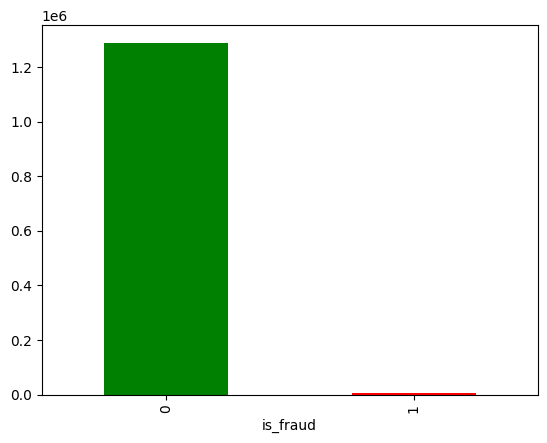

In [8]:
train_data['is_fraud'].value_counts()
train_data['is_fraud'].value_counts().plot.bar(color=['green', 'red'])

<Axes: xlabel='is_fraud'>

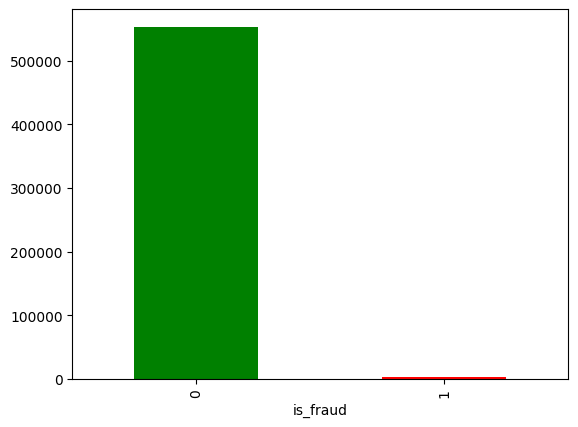

In [9]:
test_data['is_fraud'].value_counts().plot.bar(color=['green', 'red'])

### From what we see here is that the data is not balanced in the dataset.

In [10]:
# Preprocessing
X_train = train_data.drop(['is_fraud'], axis=1)
y_train = train_data['is_fraud']
X_test = test_data.drop(['is_fraud'], axis=1)
y_test = test_data['is_fraud']


#### Let's drop some unnecessary columns in our datas.

In [11]:
# Drop unnecessary columns from the training data
columns_to_drop = ['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat', 'merch_long']
X_train = X_train.drop(columns_to_drop, axis=1)

# Drop the same columns from the test data
X_test = X_test.drop(columns_to_drop, axis=1)

In [12]:
# Balance the classes in train data
oversampler = RandomOverSampler()
X_train_balanced, y_train_balanced = oversampler.fit_resample(X_train, y_train)

# Balance the classes in test data
X_test_balanced, y_test_balanced = oversampler.fit_resample(X_test, y_test)

In [13]:
# Initialize accuracy dictionaries
train_accuracies = {}
test_accuracies = {}

Next, we will quickly build a standard logistic regression model to see how it performs on such an balanced dataset.


In [14]:
# Logistic Regression
lr_model = LogisticRegression()
lr_model.fit(X_train_balanced, y_train_balanced)
lr_train_predictions = lr_model.predict(X_train_balanced)
lr_train_accuracy = accuracy_score(y_train_balanced, lr_train_predictions)

train_accuracies['Logistic Regression'] = lr_train_accuracy
lr_test_predictions = lr_model.predict(X_test_balanced)
lr_test_accuracy = accuracy_score(y_test_balanced, lr_test_predictions)
test_accuracies['Logistic Regression'] = lr_test_accuracy

### Now,let's train and test our data with decision trees

In [15]:
# Decision Trees
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train_balanced, y_train_balanced)
dt_train_predictions = dt_model.predict(X_train_balanced)
dt_train_accuracy = accuracy_score(y_train_balanced, dt_train_predictions)

train_accuracies['Decision Trees'] = dt_train_accuracy
dt_test_predictions = dt_model.predict(X_test_balanced)
dt_test_accuracy = accuracy_score(y_test_balanced, dt_test_predictions)
test_accuracies['Decision Trees'] = dt_test_accuracy

### NOW let's try random forest classifiers

In [16]:
# Random Forests
rf_model = RandomForestClassifier()
rf_model.fit(X_train_balanced, y_train_balanced)
rf_train_predictions = rf_model.predict(X_train_balanced)
rf_train_accuracy = accuracy_score(y_train_balanced, rf_train_predictions)
train_accuracies['Random Forests'] = rf_train_accuracy

rf_test_predictions = rf_model.predict(X_test_balanced)
rf_test_accuracy = accuracy_score(y_test_balanced, rf_test_predictions)
test_accuracies['Random Forests'] = rf_test_accuracy

### NOW, let's compare how well our models did in both datasets.

In [17]:
# Print train and test accuracies
print("Train Accuracies:")
for model, accuracy in train_accuracies.items():
    print(model, ":", accuracy)
    
print("\nTest Accuracies:")
for model, accuracy in test_accuracies.items():
    print(model, ":", accuracy)

Train Accuracies:
Logistic Regression : 0.49999961215325534
Decision Trees : 1.0
Random Forests : 0.9999922430651063

Test Accuracies:
Logistic Regression : 0.49999909677838916
Decision Trees : 0.5003947078439378
Random Forests : 0.500387482071051


## <strong>THANK YOU!</strong>